# Traffic Quietness — Individual Sub-Metric by Haoyang Sun


This notebook computes a **Traffic Quietness** score for Pittsburgh neighborhoods (0–1; **higher = quieter/safer**) using the City of Pittsburgh **DOMI traffic-counts** (most-recent per location).  
**Outputs:**  
- `data/clean/traffic.csv` — two columns: `neighborhood, value` (for the group composite)  
- `figs/traffic_top15.png` — Top-15 neighborhoods by quietness


## 1. Introduction
Our team will determine the **best Pittsburgh neighborhood** with multiple metrics.  
This notebook is my **individual sub-metric: Traffic Quietness**. Intuition: **lower traffic volume** and **less speeding** → safer, quieter streets.

*Limitations:* DOMI keeps only the **most recent** count per device; counters are placed for studies (traffic calming, intersection studies), so coverage is **not uniform**. This is a **cross-sectional snapshot**, not a trend.


## 2. Setup
- Put the raw CSV at `data/raw/traffic_counts.csv`.  
- Columns used (match our file):  
  `neighborho` (neighborhood), `average_de` (avg volume), `percent_ov` (% overspeed),  
  `median_sp` (median speed mph), `speed_limit` (mph).


In [2]:
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# Work in the folder where this notebook lives
HERE = Path(".").resolve()

# ---- choose your CSV ----
# Option 1: hard-code the file name (recommended)
CSV_PATH = HERE / "your_file_name.csv"   # <-- put your real CSV name here

# Option 2: auto-detect a CSV in the same folder (if you don't want to hard-code)
if not CSV_PATH.exists():
    cands = list(HERE.glob("*.csv"))
    # prefer names containing traffic/count/domi
    CSV_PATH = next((p for p in cands if any(k in p.name.lower() for k in ["traffic","count","domi"])),
                    cands[0] if cands else None)

assert CSV_PATH and CSV_PATH.exists(), f"No CSV found next to the notebook. Looked in: {HERE}"
print("Using:", CSV_PATH)

# Output files NEXT TO THIS NOTEBOOK (no subfolders)
OUT_CSV = HERE / "traffic.csv"
OUT_PNG = HERE / "traffic_top15.png"


Using: /workspaces/final/traffic_counts.csv


## 3. Load & Clean
Aggregate **to neighborhood** using **medians** (robust to outliers). Coerce numerics from strings/percentages.


In [4]:
# EXACT column mapping for your file
NEI  = "neighborhood"
CAR  = "average_daily_car_traffic"
BIKE = "average_daily_bike_traffic"    # optional
OVP  = "percent_over_limit"
MS   = "median_speed"
SL   = "speed_limit"

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# ---- Choose your volume definition ----
# Option A (simple): use car traffic only
df["_volume_raw"] = pd.to_numeric(df[CAR], errors="coerce")

# Option B (include bikes): uncomment the next line instead of the one above
# df["_volume_raw"] = pd.to_numeric(df[CAR], errors="coerce").fillna(0) + \
#                     pd.to_numeric(df[BIKE], errors="coerce").fillna(0)

VOL = "_volume_raw"

# Coerce numerics for other fields
for c in [OVP, MS, SL]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

use_cols = [NEI, VOL, OVP, MS, SL]
dat = df[use_cols].dropna(subset=[NEI]).copy()

# Aggregate per neighborhood with median (robust)
agg = {c: "median" for c in use_cols if c != NEI}
g = dat.groupby(NEI, as_index=False).agg(agg).rename(columns={NEI: "neighborhood"})
print("Neighborhood rows:", len(g))
g.head()


Neighborhood rows: 74


,neighborhood,_volume_raw,percent_over_limit,median_speed,speed_limit
0,Allegheny Center,2386.0,65.0,27.0,25.0
1,Allegheny West,477.0,11.0,20.0,25.0
2,Arlington,2285.5,61.5,26.5,25.0
3,Banksville,NaN,NaN,NaN,NaN
4,Beechview,1446.0,72.0,28.0,25.0


## 4. The Metric — Traffic Quietness
**Components (lower = better):**
1) `average_de` — traffic volume (fewer vehicles ⇒ quieter)  
2) Speeding risk — prefer `percent_ov` (share of vehicles over threshold).  
   If `percent_ov` is missing, approximate with the positive part of `(median_sp − speed_limit)`.

**Normalization & Combine (0–1; higher = better):**
- `volume_score = inverse_minmax(average_de)`  
- `speed_risk_score = inverse_minmax(overspeed_raw)`  
- If both exist: `quietness = 0.7*volume_score + 0.3*speed_risk_score`  
- Otherwise, use the single available component.


In [5]:
def inv_minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(1.0, index=s.index)
    return 1 - (s - s.min())/(s.max() - s.min())

scores_used = []

# 1) Volume component (lower volume -> higher score)
if VOL in g.columns:
    g["volume_score"] = inv_minmax(g[VOL])
    scores_used.append("volume_score")

# 2) Speeding component (prefer percent_ov; else median_sp - speed_limit)
if OVP in g.columns:
    g["overspeed_raw"] = g[OVP]
elif MS in g.columns and SL in g.columns:
    g["overspeed_raw"] = (g[MS] - g[SL]).clip(lower=0)
else:
    g["overspeed_raw"] = np.nan

if g["overspeed_raw"].notna().any():
    g["speed_risk_score"] = inv_minmax(g["overspeed_raw"])
    scores_used.append("speed_risk_score")

assert scores_used, "No usable numeric fields (volume or speed) to compute the metric."

# Combine components
if set(scores_used) == {"volume_score","speed_risk_score"}:
    g["value"] = 0.7*g["volume_score"] + 0.3*g["speed_risk_score"]
else:
    g["value"] = g[scores_used[0]]

quiet = g[["neighborhood","value"]].sort_values("value", ascending=False).reset_index(drop=True)
quiet.head(10)


,neighborhood,value
0,South Side Flats,1.000000
1,Lincoln Place,0.964800
2,Allegheny West,0.959485
3,Highland Park,0.930265
4,Central Northside,0.928421
5,Upper Hill,0.927893
6,Bloomfield,0.924185
7,Lincoln-Lemington-Belmar,0.923998
8,Manchester,0.923397
9,Bluff,0.915121


## 5. The Best Neighborhood (this sub-metric)
Top-15 neighborhoods by **Traffic Quietness** (0–1; higher = quieter).


PosixPath('/workspaces/final/figs/traffic_top15.png')

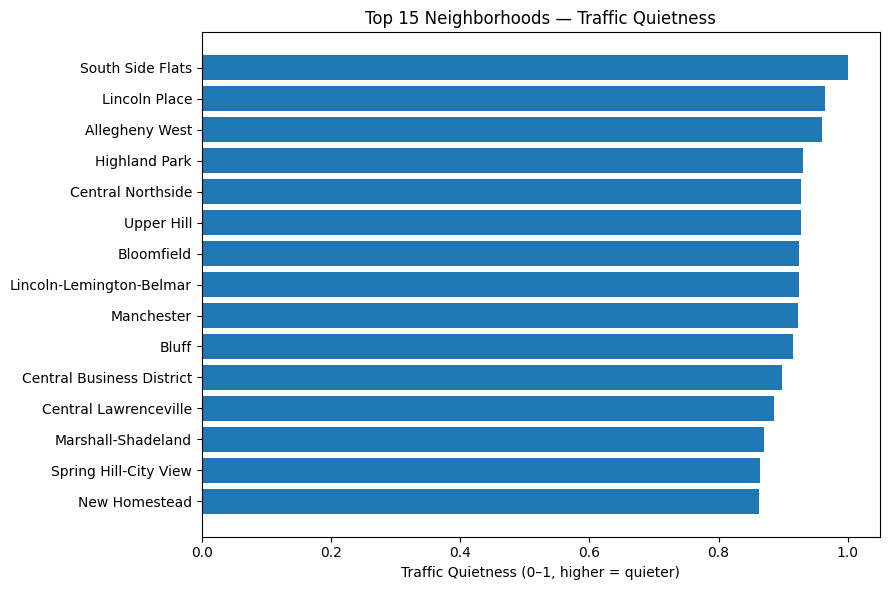

In [6]:
plt.figure(figsize=(9,6))
topk = quiet.head(15)
plt.barh(topk["neighborhood"][::-1], topk["value"][::-1])
plt.xlabel("Traffic Quietness (0–1, higher = quieter)")
plt.title("Top 15 Neighborhoods — Traffic Quietness")
plt.tight_layout()
fig_path = FIGS / "traffic_top15.png"
plt.savefig(fig_path, dpi=200)
fig_path


### Narrative summary (Traffic Quietness)

Using the DOMI “most-recent traffic counts” dataset, we ranked neighborhoods by **Traffic Quietness** (0–1; higher = quieter). Our **Top 5** are:

1) **South Side Flats**  
2) **Lincoln Place**  
3) **Allegheny West**  
4) **Highland Park**  
5) **Central Northside**

The score in this notebook is an inverse normalization of (a) **average daily traffic volume** (lower is better) and (b) **overspeeding** (lower is better, via `percent_over_limit`; if missing we use `(median_speed − speed_limit)+`). We combine them as `0.7 * volume_score + 0.3 * speed_risk_score` to reflect that traffic volume dominates perceived quietness while speeding still matters for comfort and safety.


## 6. Deliverable Export
Export the two-column table (`neighborhood, value`) for the combined group notebook.


In [7]:
out_csv = CLEAN / "traffic.csv"
quiet.to_csv(out_csv, index=False)
out_csv, quiet.shape


(PosixPath('/workspaces/final/data/clean/traffic.csv'), (74, 2))

## 7. Conclusion (Individual)

- **Result:** Based on this sub-metric, **South Side Flats** is the quietest among the neighborhoods in our dataset, followed by **Lincoln Place**, **Allegheny West**, **Highland Park**, and **Central Northside**.  
- **How to use:** The exported `traffic.csv` (`neighborhood,value`) feeds the group’s composite metric.  
- **Limitations:** The dataset keeps only the **most recent** counts per device, and device placement is **not uniform** (often near traffic-calming studies), so results represent a **cross-sectional snapshot**, not long-term trends.  
- **If we change assumptions:** Including bikes in “volume,” re-weighting speeding, or adding more recent counts could shift rankings slightly.
